# 1. Introduction

## 1.1 Project Overview

The objective of this project is to develop a machine learning model capable of classifying images of animals into their respective categories. This classification task is crucial for applications in wildlife monitoring, automated animal detection in images, and educational tools in zoology and biodiversity.

## 1.2 Dataset

The dataset used for this project is the Cifar10 dataset, which contains images of ten different classes. The dataset includes a total of 60,000 with each class having a diverse set of images representing various poses, backgrounds, and lighting conditions. The ten classes are:

 * Airplane
 * Automobile
 * Bird
 * Cat
 * Deer
 * Dog
 * Frog
 * Horse
 * Ship
 * Truck

Each class has 6,000 images in JPEG format and come in 32x32 format, reflecting real-world scenarios.


## 1.3 Tools and Technologies

* Programming Language: Python
* Python Libraries:
    * NumPy
    * Pandas
    * Scikit-Learn
    * Matplotlib
    * Seaborn
    * Keras
    * PIL
* Development Environment: Jupyter Notebook
* Web Framework: Flask




# 2. Data Exploration and Preprocessing

First, I'm importing all the libraries that I know I'll need from top of mind.
Other libraries will be added as needed, in the report.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Dropout, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3



Load the CIFAR-10 dataset and start the preprocessing steps:

In [3]:
from tensorflow.keras.datasets import cifar10
#Load the data from keras.datasets (already-vectorized, in Numpy format)

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

#Split the data into training set and validation, considering a test size of 30% of the total data
#The train_test_split is initialized with random_state = 1 so it returns the same results for each execution

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.3, random_state=1)


### 2.1. Data Exploration

Initially, I explored the dataset to understand its structure and characteristics. This included:

* Dataset Structure: I checked the shape for the images of all sets and the available classes.


In [5]:
# Print shape of the dataset
print(f'Train images shape: {train_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test images shape: {val_images.shape}')

Train images shape: (35000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Test images shape: (15000, 32, 32, 3)


In [27]:
# Defining the class names

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


print("This dataset contains the following classes:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

This dataset contains the following classes:
0: Airplane
1: Automobile
2: Bird
3: Cat
4: Deer
5: Dog
6: Frog
7: Horse
8: Ship
9: Truck



* **Class Distribution**: I checked the distribution of images across different classes to ensure there is a balance. If the classes were imbalanced, this could affect the performance of the model.



In [28]:
# Initialize a dictionary to store counts
class_count = {class_name: 0 for class_name in class_names}

# Count the occurrences of each class label
for label in train_labels:
    class_name = class_names[label[0]]  # label is a single integer
    class_count[class_name] += 1

# Print the counts
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Airplane: 3511
Automobile: 3490
Bird: 3461
Cat: 3485
Deer: 3522
Dog: 3508
Frog: 3475
Horse: 3489
Ship: 3540
Truck: 3519


* Image Dimensions and Formats: I verified the dimensions and formats of the images to standardize preprocessing steps. The images were in JPEG format, with dimension 32x32.

In [29]:
# Print sample image formats and dimensions
for i in range(5):  # Print information for the first 5 images
    image = train_images[i]
    label = train_labels[i]
    class_name = class_names[label[0]]
    print(f"Sample {i+1}:")
    print(f"Class: {class_name}")
    print(f"Image Format: {image.dtype}")
    print(f"Image Dimensions: {image.shape}")
    print()

Sample 1:
Class: Frog
Image Format: uint8
Image Dimensions: (32, 32, 3)

Sample 2:
Class: Ship
Image Format: uint8
Image Dimensions: (32, 32, 3)

Sample 3:
Class: Automobile
Image Format: uint8
Image Dimensions: (32, 32, 3)

Sample 4:
Class: Bird
Image Format: uint8
Image Dimensions: (32, 32, 3)

Sample 5:
Class: Bird
Image Format: uint8
Image Dimensions: (32, 32, 3)



* Sample Visualization: I also visualized random samples from each class to get an intuition about the dataset and identify any anomalies or variations in the images that might require specific preprocessing steps.

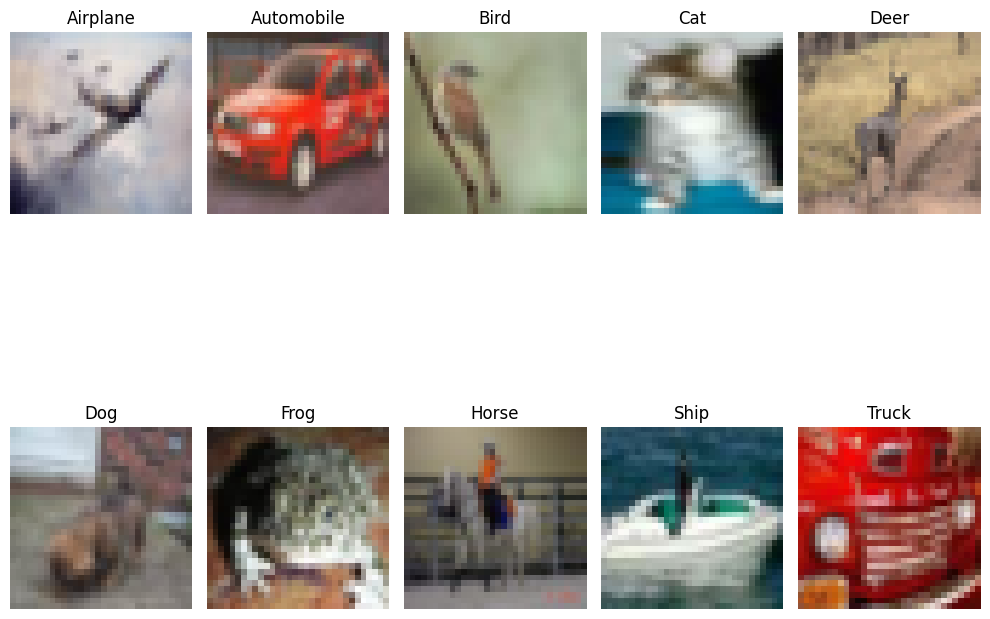

In [30]:

# Plotting sample images from each class
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,10))
axes = axes.flatten()
for ax, class_name in zip(axes, class_names):
    # Find the first image of the current class
    index = next(i for i, label in enumerate(train_labels) if label[0] == class_names.index(class_name))
    img = train_images[index]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()


### 2.2 Data Preprocessing

Data preprocessing steps included:

* Handling Missing Values: There were no missing values in the dataset since all data points are images stored in directories.


In [31]:
# Check for any NaN values
print(np.isnan(train_images).sum(), np.isnan(train_labels).sum())
print(np.isnan(val_images).sum(), np.isnan(val_labels).sum())
print(np.isnan(test_images).sum(), np.isnan(test_labels).sum())


0 0
0 0
0 0


* Data Augmentation: To enhance model generalization, I applied several augmentation techniques:

 * Horizontal Flip: Randomly flipping images horizontally.
 * Zooming: Randomly zooming into images.
 * Width and Height Shifts: Randomly shifting images horizontally and vertically.
 * Rotation: Randomly rotating images within a specified range.

In [32]:
# Create ImageDataGenerators for training and validation sets
data_generator = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    horizontal_flip = True,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

 # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
data_generator.fit(train_images)


* Image Resizing and Scaling: All images were resized to a uniform size of 200x200 pixels to ensure consistency. We also rescaled pixel values to the range [0, 1] by dividing by 255.0.

In [33]:
# Normalizing the data pixels value to [0,1]
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0


# Create ImageDataGenerator for test set
test_val_data_generator = ImageDataGenerator(rescale=1./255.0)




## 3. Model Development

### 3.1 Model Selection

The first phase of the project implied creating a custom made Convolutional Neural Network architecture, that would be suitable for image classification tasks.

In the first few iterations of the model, I started with a simpler structure, with less layers.

At the final stage, I noticed that the model precision, f1 score and accuracy performed badly for the validation and test sets, so I introduced reLU activation.

MReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero and to introduce non-linearity to the network
Other non linear functions such as tanh or sigmoid can also be used instead of ReLU, but ReLU has been found to perform better in most situations gradually reduce the spatial dimensions through the network while still allowing the filters to have a sufficient receptive field in the second layer.

The final CNN model included layers such as convolutional layers, batch normalization, ReLU activation, max pooling, and dropout to reduce overfitting. The model was trained with the SGD optimizer and sparse categorical cross-entropy loss function, achieving reasonable accuracy on both the training and validation datasets.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

cnn_model = tf.keras.models.Sequential([
    Conv2D(64, (4, 4), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (4, 4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (4, 4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (4, 4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn_model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 1,519,114 (5.79 MB)

 Trainable params: 1,518,090 (5.79 MB)

 Non-trainable params: 1,024 (4.00 KB)

Input Layer: The model starts by accepting input images of size 32x32 pixels with 3 color channels (RGB), typical for color images.

First Convolutional Block: The first block begins with a convolutional layer that has 64 filters, each of size 4x4. This layer scans the input image and creates 64 different feature maps. The activation function used here is ReLU, which introduces non-linearity into the model. Following this, I apply a max-pooling layer with a 2x2 pool size and a dropout layer. These layers help the model detect various features like edges and textures in the images while also controlling overfitting.

Second Convolutional Block: The second block is similar to the first one but with the same number of filters. It further refines the patterns detected by the first block.

Third Convolutional Block: The third block has a convolutional layer with 128 filters. This increases the depth of the feature maps, allowing the model to learn more complex patterns.

Fourth Convolutional Block: The fourth block has a convolutional layer with 256 filters. This further increases the depth of the feature maps, allowing the model to learn even more complex patterns.

Flatten Layer: At this point, the 3D feature maps are flattened into a 1D vector. This transformation is necessary to connect the convolutional layers to the fully connected (dense) layers.

Fully Connected Layers: I then add a dense layer with 512 neurons and ReLU activation. This layer learns the final patterns and representations needed for classification. To further prevent overfitting, I add another dropout layer here. Another dense layer with 512 neurons and ReLU activation follows, this time with L2 regularization.

Output Layer: Finally, there is a dense layer with 10 neurons, corresponding to the 10 classes in the CIFAR-10 dataset. This layer uses a softmax activation function to produce a probability distribution over the classes, allowing the model to make a final classification decision.

### 3.2 Model Training and Evaluation

The model was compiled with the Adam optimizer, utilizing a learning rate of 0.0001, and categorical cross-entropy loss function, aiming to optimize accuracy during training.



In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

**Early Stopping and ReduceLROnPlateau**

To monitor and control the training process, two callback functions were implemented: EarlyStopping and ReduceLROnPlateau.

EarlyStopping was set to monitor validation loss and halt training if there was no improvement after 10 consecutive epochs.

ReduceLROnPlateau was employed to adjust the learning rate dynamically by a factor of 0.2 if no improvement in validation loss was observed after 5 epochs, with a lower limit set to 0.001.



In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

The model was trained using the fit method with the provided training set (train_set) and validated against the validation set (val_set) over 100 epochs.

Subsequently, the model's performance was evaluated on both the validation and test sets. The evaluation included measuring accuracy, along with generating classification reports to gain insights into the model's performance across different classes.

Results for the first model with SGD optimizer and lr=0.0001

The training stopped at the 20th epoch as the loss was not dropping. The model is also inneficient, as it only reached 0.0999 accuracy, showing that the layers aren't enough to capture the necessary features.


In [37]:
from tensorflow.keras.utils import to_categorical

history = cnn_model.fit(
    data_generator.flow(train_images, to_categorical(train_labels)),
    epochs = 100,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=[early_stopping, reduce_lr],batch_size=128
)

Epoch 1/100
1094/1094 [==============================] - 31s 27ms/step - loss: 2.7172 - accuracy: 0.1709 - val_loss: 2.3574 - val_accuracy: 0.2505
Epoch 2/100
1094/1094 [==============================] - 26s 23ms/step - loss: 2.4129 - accuracy: 0.2303 - val_loss: 2.1440 - val_accuracy: 0.3224
Epoch 3/100
1094/1094 [==============================] - 27s 25ms/step - loss: 2.2455 - accuracy: 0.2640 - val_loss: 1.9467 - val_accuracy: 0.3693
Epoch 4/100
1094/1094 [==============================] - 27s 25ms/step - loss: 2.1094 - accuracy: 0.2901 - val_loss: 1.8822 - val_accuracy: 0.3713
Epoch 5/100
1094/1094 [==============================] - 27s 25ms/step - loss: 2.0022 - accuracy: 0.3123 - val_loss: 1.8182 - val_accuracy: 0.3829
Epoch 6/100
1094/1094 [==============================] - 30s 28ms/step - loss: 1.9159 - accuracy: 0.3322 - val_loss: 1.7435 - val_accuracy: 0.4155
Epoch 7/100
1094/1094 [==============================] - 26s 24ms/step - loss: 1.8607 - accuracy: 0.3471 - val_loss: 1

## 4. Results

### 4.1 Model Performance Evaluation

The visualizations below illustrate the training and validation loss, as well as the training and validation accuracy over the course of the training epochs.

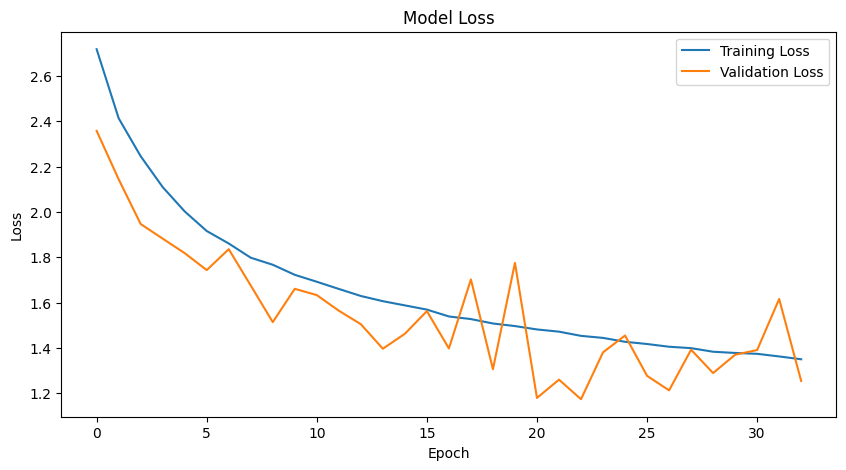

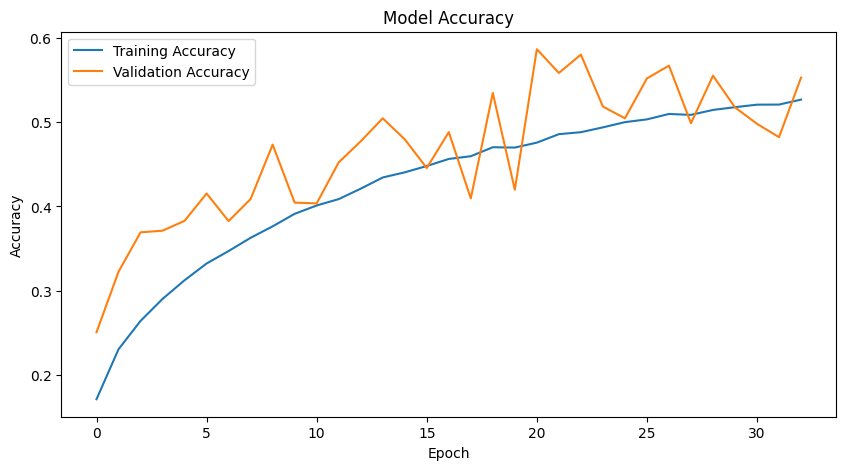

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Evaluating the model with the validation set**

In [39]:
test_loss_val, test_acc_val = cnn_model.evaluate(val_images, to_categorical(val_labels))
print(f"Validation Set \n Test accuracy: {test_acc_val}\nTest Loss:{test_loss_val}")

469/469 [==============================] - 2s 5ms/step - loss: 1.1743 - accuracy: 0.5805
Validation Set 
 Test accuracy: 0.5805333256721497
Test Loss:1.1742583513259888


**Evaluating the model with a test set**

In [40]:
test_loss_test, test_acc_test = cnn_model.evaluate(test_images, to_categorical(test_labels))
print(f"Validation Set /n Test accuracy: {test_acc_test}/nTest Loss:{test_loss_test}")

313/313 [==============================] - 2s 5ms/step - loss: 1.1839 - accuracy: 0.5766
Validation Set /n Test accuracy: 0.5766000151634216/nTest Loss:1.1838736534118652


**Model's accuracy, precision, recall, and F1-score**

In [41]:
from sklearn.metrics import classification_report, accuracy_score


# Assuming val_labels is already defined and matches the validation set
validation_true_labels = val_labels.flatten()  # Flatten in case val_labels is of shape (n, 1)

# Predict on the validation set
validation_pred = cnn_model.predict(val_images)
validation_pred_labels = np.argmax(validation_pred, axis=1)

# Calculate the accuracy
acc_val = accuracy_score(validation_true_labels, validation_pred_labels)

# Print the accuracy
print(f"Validation Set Accuracy: {acc_val}")

# Generate a classification report
print("Validation Set - Classification Report:")
print(classification_report(validation_true_labels, validation_pred_labels, target_names=class_names))
print(validation_pred_labels)




Validation Set Accuracy: 0.5805333333333333
Validation Set - Classification Report:
              precision    recall  f1-score   support

    Airplane       0.65      0.69      0.67      1489
  Automobile       0.72      0.74      0.73      1510
        Bird       0.67      0.23      0.34      1539
         Cat       0.43      0.26      0.32      1515
        Deer       0.58      0.34      0.43      1478
         Dog       0.56      0.43      0.48      1492
        Frog       0.41      0.90      0.56      1525
       Horse       0.58      0.73      0.64      1511
        Ship       0.75      0.81      0.78      1460
       Truck       0.66      0.70      0.68      1481

    accuracy                           0.58     15000
   macro avg       0.60      0.58      0.56     15000
weighted avg       0.60      0.58      0.56     15000

[8 7 0 ... 1 6 7]


**Validation Set Confusion Matrix**

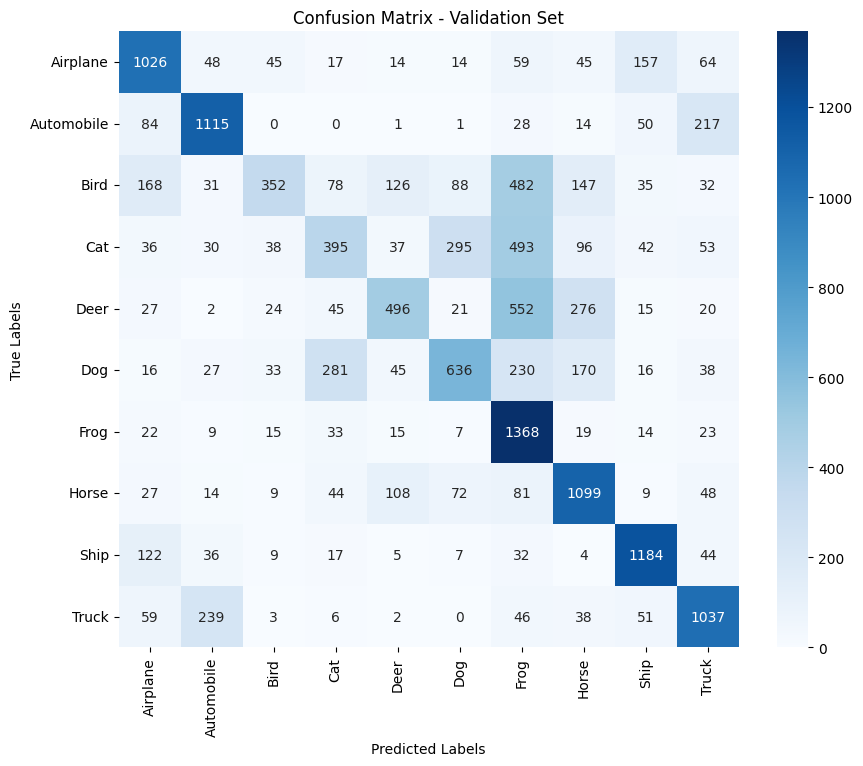

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Confusion matrix
conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

**Model's accuracy, precision, recall, and F1-score**

In [43]:
from sklearn.metrics import classification_report, accuracy_score


# Assuming val_labels is already defined and matches the validation set
test_true_labels = test_labels.flatten()  # Flatten in case val_labels is of shape (n, 1)

# Predict on the validation set
test_pred = cnn_model.predict(test_images)
test_pred_labels = np.argmax(test_pred, axis=1)

# Calculate the accuracy
acc_test = accuracy_score(test_true_labels, test_pred_labels)

# Print the accuracy
print(f"Validation Set Accuracy: {acc_test}")

# Generate a classification report
print("Validation Set - Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))
print(test_pred_labels)




Validation Set Accuracy: 0.5766
Validation Set - Classification Report:
              precision    recall  f1-score   support

    Airplane       0.63      0.67      0.65      1000
  Automobile       0.73      0.74      0.74      1000
        Bird       0.64      0.20      0.30      1000
         Cat       0.44      0.26      0.33      1000
        Deer       0.57      0.30      0.40      1000
         Dog       0.55      0.43      0.48      1000
        Frog       0.40      0.90      0.55      1000
       Horse       0.59      0.75      0.66      1000
        Ship       0.75      0.79      0.77      1000
       Truck       0.65      0.71      0.68      1000

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.56     10000
weighted avg       0.59      0.58      0.56     10000

[3 8 8 ... 5 1 7]


**Test Set Confusion Matrix**

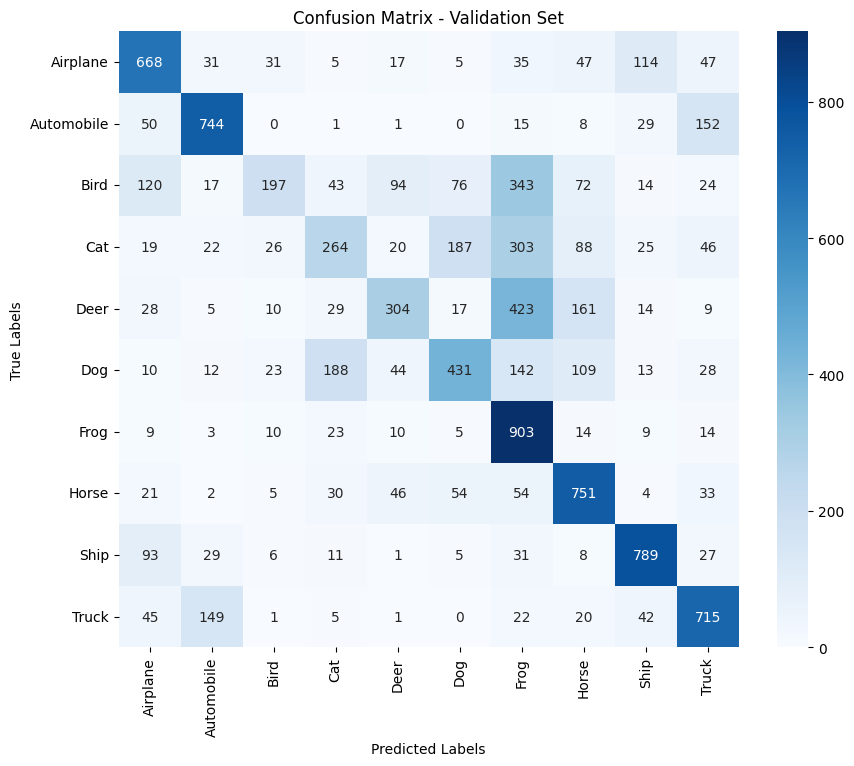

In [44]:
#Confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

Although the model doesn't have a high accuracy on both the validation and test sets, the confusion matrix doesn't reflect it too much.

## Saving the model

Since my goal is to save the original model and the last model, I'm creating a function to save a model that can be reused further.

In [45]:
import os

def save_model(model, model_dir="./model", model_version=1):
    """
    Save the given TensorFlow model in SavedModel format for TensorFlow Serving.

    Parameters:
    - model: tf.keras.Model
        The trained model to be saved.
    - model_dir: str
        The directory where the model will be saved.
    - model_version: int
        The version number of the model.

    Returns:
    - str
        The path to the saved model.
    """
    model_export_path = f"{model_dir}/{model_version}"

    # Create model_dir if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the model
    tf.saved_model.save(model, export_dir=model_export_path)

    # List the saved files
    saved_files = os.listdir(model_export_path)
    print(f"SavedModel files: {saved_files}")

    return model_export_path

In [46]:
model_export_path = save_model(cnn_model)
print(f"Model saved at: {model_export_path}")


INFO:tensorflow:Assets written to: ./model/1\assets
SavedModel files: ['assets', 'saved_model.pb', 'variables']
Model saved at: ./model/1


## 5. Transfer Learning

After evaluating the performance of the initial CNN model, transfer learning was employed to improve the model's accuracy and generalization capabilities.

The following pre-trained models were considered for transfer learning:

* **VGG16**: VGG16 is a popular deep learning model with 16 layers, known for its simplicity and effectiveness in image classification tasks. Its architecture consists of sequential convolutional layers followed by fully connected layers.

* **ResNet50**: ResNet50, a 50-layer residual network, introduces skip connections to address the vanishing gradient problem, enabling the training of deeper networks. It has shown superior performance in various image classification benchmarks.

* **InceptionV3**: InceptionV3, part of the Inception family of models, uses a more complex architecture with inception modules that allow the network to learn richer feature representations by combining multiple convolutional filters.

### 5.1 Removing the first layer and performing transfer learning using pre-trained models

In [47]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Load the pre-trained models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Create models based on pre-trained models
def create_model(base_model):
    """
    This function creates a new model based on a pre-trained model.

    The function starts by setting the 'trainable' attribute of all layers in the base model to False, 
    effectively freezing them. This is done to preserve the features learned by the base model.

    The output of the base model is then flattened and passed through a series of layers:
    - A dense layer with 128 units and ReLU activation
    - A dropout layer with a rate of 0.5 to prevent overfitting
    - A final dense layer with 10 units (for 10 classes) and softmax activation to output probabilities

    The function finally creates a new Model instance with the same input as the base model but with the 
    newly added layers as output.

    Args:
        base_model (tf.keras.Model): The pre-trained model to base the new model on.

    Returns:
        model (tf.keras.Model): The newly created model.
    """
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

vgg16_model = create_model(vgg16_base)
resnet50_model = create_model(resnet50_base)
inceptionv3_model = create_model(inceptionv3_base)


In [50]:
# Convert target labels to one-hot encoded arrays
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)

# Adjust image sizes for InceptionV3
with tf.device('/cpu:0'):
    _train_images_inceptionv3 = tf.image.resize(train_images, (75, 75))
    _val_images_inceptionv3 = tf.image.resize(val_images, (75, 75))
    _test_images_inceptionv3 = tf.image.resize(test_images, (75, 75))

# Create InceptionV3 base model
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75,75,3))

# Add custom top layers
inceptionv3_model = create_model(inceptionv3_base)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
inceptionv3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_inceptionV3 = inceptionv3_model.fit(_train_images_inceptionv3, train_labels_one_hot, epochs=20, validation_data=(_val_images_inceptionv3, val_labels_one_hot))


Epoch 1/20
1094/1094 [==============================] - 46s 34ms/step - loss: 1.8947 - accuracy: 0.3327 - val_loss: 1.4484 - val_accuracy: 0.5146
Epoch 2/20
1094/1094 [==============================] - 35s 32ms/step - loss: 1.4769 - accuracy: 0.4812 - val_loss: 1.2744 - val_accuracy: 0.5651
Epoch 3/20
1094/1094 [==============================] - 37s 34ms/step - loss: 1.3377 - accuracy: 0.5332 - val_loss: 1.2080 - val_accuracy: 0.5871
Epoch 4/20
1094/1094 [==============================] - 35s 32ms/step - loss: 1.2557 - accuracy: 0.5629 - val_loss: 1.1689 - val_accuracy: 0.6005
Epoch 5/20
1094/1094 [==============================] - 34s 31ms/step - loss: 1.1990 - accuracy: 0.5828 - val_loss: 1.1427 - val_accuracy: 0.6087
Epoch 6/20
1094/1094 [==============================] - 35s 32ms/step - loss: 1.1527 - accuracy: 0.5991 - val_loss: 1.1234 - val_accuracy: 0.6147
Epoch 7/20
1094/1094 [==============================] - 35s 32ms/step - loss: 1.1222 - accuracy: 0.6099 - val_loss: 1.1106 -

In [53]:

# Convert target labels to one-hot encoded arrays
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)


# Resize train and validation images to match VGG16 input size
with tf.device('/cpu:0'):
  _train_images_vgg16 = tf.image.resize(train_images, (32, 32))
  _val_images_vgg16 = tf.image.resize(val_images, (32, 32))

# Create InceptionV3 base model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers
vgg16_model = create_model(vgg16_base)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = vgg16_model.fit(_train_images_vgg16, train_labels_one_hot, epochs=20, validation_data=(_val_images_vgg16, val_labels_one_hot))


Epoch 1/20
1094/1094 [==============================] - 28s 23ms/step - loss: 2.0423 - accuracy: 0.2703 - val_loss: 1.7037 - val_accuracy: 0.4491
Epoch 2/20
1094/1094 [==============================] - 21s 20ms/step - loss: 1.7127 - accuracy: 0.4021 - val_loss: 1.5286 - val_accuracy: 0.4932
Epoch 3/20
1094/1094 [==============================] - 22s 20ms/step - loss: 1.5958 - accuracy: 0.4446 - val_loss: 1.4454 - val_accuracy: 0.5141
Epoch 4/20
1094/1094 [==============================] - 22s 20ms/step - loss: 1.5208 - accuracy: 0.4724 - val_loss: 1.3907 - val_accuracy: 0.5267
Epoch 5/20
1094/1094 [==============================] - 22s 20ms/step - loss: 1.4767 - accuracy: 0.4875 - val_loss: 1.3583 - val_accuracy: 0.5368
Epoch 6/20
1094/1094 [==============================] - 22s 20ms/step - loss: 1.4404 - accuracy: 0.4987 - val_loss: 1.3265 - val_accuracy: 0.5465
Epoch 7/20
1094/1094 [==============================] - 22s 20ms/step - loss: 1.4052 - accuracy: 0.5127 - val_loss: 1.3046 -

In [54]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Adjust image sizes for ResNet50
with tf.device('/cpu:0'):
  _train_images_resnet50 = tf.image.resize(train_images, (32, 32))
  _val_images_resnet50 = tf.image.resize(val_images, (32, 32))

# Convert target labels to one-hot encoded arrays
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)

# Create ResNet50 base model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers for ResNet50
resnet50_model = create_model(resnet50_base)

# Compile the ResNet50 model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet50_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model
history_resnet50 = resnet50_model.fit(_train_images_resnet50, train_labels_one_hot, epochs=20, validation_data=(_val_images_resnet50, val_labels_one_hot))


Epoch 1/20
1094/1094 [==============================] - 35s 26ms/step - loss: 2.3249 - accuracy: 0.1523 - val_loss: 2.1926 - val_accuracy: 0.2417
Epoch 2/20
1094/1094 [==============================] - 26s 24ms/step - loss: 2.1932 - accuracy: 0.1906 - val_loss: 2.1234 - val_accuracy: 0.2569
Epoch 3/20
1094/1094 [==============================] - 27s 25ms/step - loss: 2.1342 - accuracy: 0.2217 - val_loss: 2.0612 - val_accuracy: 0.2819
Epoch 4/20
1094/1094 [==============================] - 28s 25ms/step - loss: 2.0956 - accuracy: 0.2315 - val_loss: 2.0215 - val_accuracy: 0.2866
Epoch 5/20
1094/1094 [==============================] - 28s 26ms/step - loss: 2.0606 - accuracy: 0.2445 - val_loss: 1.9828 - val_accuracy: 0.3002
Epoch 6/20
1094/1094 [==============================] - 28s 26ms/step - loss: 2.0393 - accuracy: 0.2531 - val_loss: 1.9699 - val_accuracy: 0.3139
Epoch 7/20
1094/1094 [==============================] - 28s 26ms/step - loss: 2.0198 - accuracy: 0.2631 - val_loss: 1.9442 -

In [56]:
# Evaluate the InceptionV3 model on the preprocessed validation images
evaluation_results_inceptionv3 = inceptionv3_model.evaluate(_val_images_inceptionv3, val_labels_one_hot)

print("Evaluation Results on InceptionV3:")
print("Loss:", evaluation_results_inceptionv3[0])
print("Accuracy:", evaluation_results_inceptionv3[1])


469/469 [==============================] - 11s 23ms/step - loss: 1.0718 - accuracy: 0.6316
Evaluation Results on InceptionV3:
Loss: 1.0718142986297607
Accuracy: 0.631600022315979


In [57]:
# Evaluate the VGG16 model on the preprocessed validation images
evaluation_results_vgg = vgg16_model.evaluate(_val_images_vgg16, val_labels_one_hot)

print("Evaluation Results on VGG16:")
print("Loss:", evaluation_results_vgg[0])
print("Accuracy:", evaluation_results_vgg[1])


469/469 [==============================] - 7s 14ms/step - loss: 1.1769 - accuracy: 0.5938
Evaluation Results on VGG16:
Loss: 1.1769468784332275
Accuracy: 0.5938000082969666


In [58]:
# Evaluate the VGG16 model on the preprocessed validation images
evaluation_results_resnet = resnet50_model.evaluate(_val_images_resnet50, val_labels_one_hot)

print("Evaluation Results on ResNet50:")
print("Loss:", evaluation_results_resnet[0])
print("Accuracy:", evaluation_results_resnet[1])


469/469 [==============================] - 8s 18ms/step - loss: 1.8163 - accuracy: 0.3595
Evaluation Results on ResNet50:
Loss: 1.816328763961792
Accuracy: 0.3595333397388458



**InceptionV3**

The inception modules provide a diverse set of feature representations, potentially leading to better performance in complex datasets.
Showed competitive accuracy on the validation and test sets, much higher than the other two models which makes it my chosen model.

### 5.2 Transfer Learning Evaluation

**Final Model Selection**

CIFAR-10 is a relatively small dataset with low-resolution images (32x32 pixels) and contains 10 classes of objects. Pre-trained models like VGG, Inception, and ResNet are trained on much larger datasets like ImageNet, which contains millions of high-resolution images across thousands of classes.

The final model selected was Inception due to its balance of complexity and performance. Additionally, Inception was further fine-tuned by unfreezing the last few layers and retraining them to adapt specifically to the CIFAR-10 dataset. This fine-tuning process further improved the model’s accuracy.

Performance: Inception demonstrated strong performance on the validation and test sets, indicating its ability to generalize well to new images.
Complexity: The complex architecture of Inception allowed it to learn more intricate patterns and features compared to simpler models like VGG.
Resource Efficiency: Despite its complexity, Inception was efficient in terms of computational resources, making it a practical choice for this project.
Overall, Inception provided a good balance of accuracy, complexity, and computational efficiency, making it the ideal choice for the object classification task on the CIFAR-10 dataset.



In [60]:
with tf.device('/cpu:0'):
  _test_images_inceptionv3 = tf.image.resize(test_images, (32, 32))

test_labels_one_hot = to_categorical(test_labels)


# Unfreeze the last 5 layers of the VGG model
for layer in inceptionv3_model.layers[-5:]:
    layer.trainable = True

# Compile the model with the updated trainable parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
inceptionv3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training data and validate using the validation data
history_final = inceptionv3_model.fit(_train_images_inceptionv3, train_labels_one_hot, epochs=20, validation_data=(_val_images_inceptionv3, val_labels_one_hot)) 

Epoch 1/20
1094/1094 [==============================] - 48s 39ms/step - loss: 1.1142 - accuracy: 0.6045 - val_loss: 1.1459 - val_accuracy: 0.6000
Epoch 2/20
1094/1094 [==============================] - 38s 35ms/step - loss: 1.0736 - accuracy: 0.6201 - val_loss: 1.1087 - val_accuracy: 0.6158
Epoch 3/20
1094/1094 [==============================] - 39s 35ms/step - loss: 1.0333 - accuracy: 0.6347 - val_loss: 1.1033 - val_accuracy: 0.6194
Epoch 4/20
1094/1094 [==============================] - 38s 35ms/step - loss: 0.9915 - accuracy: 0.6473 - val_loss: 1.1081 - val_accuracy: 0.6170
Epoch 5/20
1094/1094 [==============================] - 39s 35ms/step - loss: 0.9668 - accuracy: 0.6543 - val_loss: 1.1130 - val_accuracy: 0.6188
Epoch 6/20
1094/1094 [==============================] - 41s 38ms/step - loss: 0.9326 - accuracy: 0.6660 - val_loss: 1.1307 - val_accuracy: 0.6221
Epoch 7/20
1094/1094 [==============================] - 41s 38ms/step - loss: 0.8883 - accuracy: 0.6827 - val_loss: 1.1439 -

ValueError: in user code:

    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1333 test_function  *
        return step_function(self, iterator)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1324 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1317 run_step  **
        outputs = model.test_step(data)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1276 test_step
        y_pred = self(x, training=False)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\Bernardo Rodrigues\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_6: expected shape=(None, 75, 75, 3), found shape=(None, 32, 32, 3)


313/313 [==============================] - 11s 35ms/step - loss: 1.3805 - accuracy: 0.6108
Final Model Test accuracy: 0.61080002784729


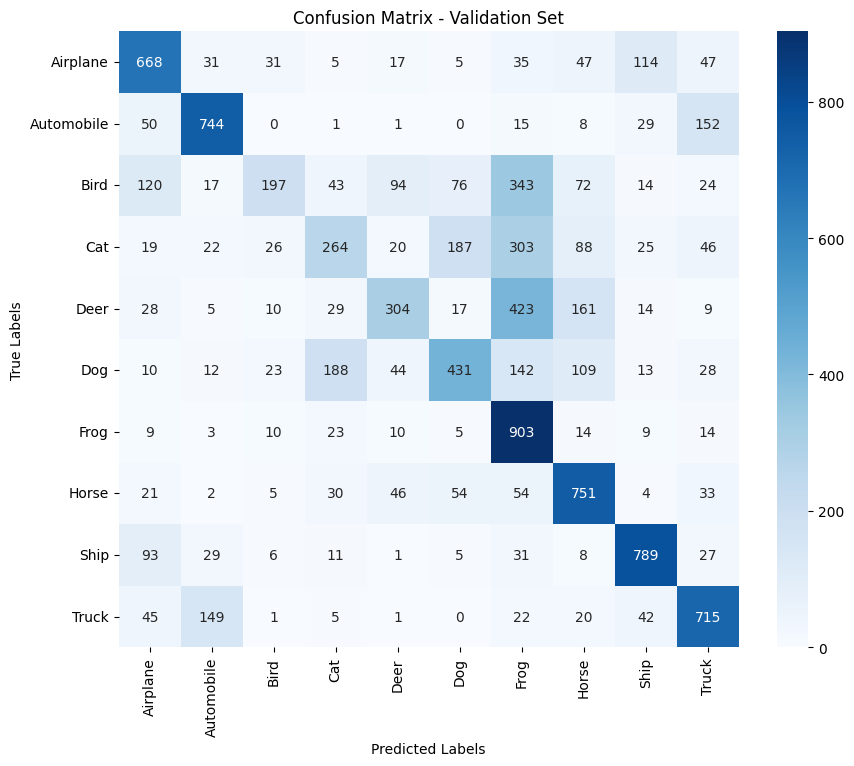

In [62]:
# Evaluate the model
test_labels_one_hot = to_categorical(test_labels)

test_loss_final, test_acc_final = inceptionv3_model.evaluate(_test_images_inceptionv3, test_labels_one_hot)
print(f"Final Model Test accuracy: {test_acc_final}")


#Confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

In [63]:
model_export_path = save_model(inceptionv3_model)
print(f"Model saved at: {model_export_path}")

INFO:tensorflow:Assets written to: ./model/1\assets
SavedModel files: ['assets', 'saved_model.pb', 'variables']
Model saved at: ./model/1
